# Stock Price Forecast Using ARIMA Model
> In this notebook i'm going to forecast the stock price of The Procter & Gamble Company (Ticker PG) using the Auto Regressive Integrated Moving Average (ARIMA) model

- toc: true
- badges: true
- categories:[Quantitative Research]
- image:images/time series.png

### **DISCLAIMER!**
*Before proceeding, please make sure that you note the following important information*:

*NOT FINANCIAL ADVICE!*

*My content is intended to be used and must be used for informational and educational purposes only*. 
*I am not an attorney, CPA, or financial advisor, nor am I holding myself out to be, and the information contained on this blog/notebook is not a substitute for financial advice, None of the information contained here constitutes an offer (or solicitation of an offer) to buy or sell any security or financial instrument to make any investment or to participate in any particular trading strategy. Always seek advice from a professional who is aware of the facts and circumstances of your individual situation. Or, Independently research and verify any information that you find on my blog/notebook and wish to rely upon in making any investment decision or otherwise. I accept no liability whatsoever for any loss or damage you may incur* 

### **Intro on time series**:
A time series is a sequence of data that attaches a time period to each value, the value can be anything measurable that depends on time in some way like rainfall measurements, heart rate measurements, annual retail sales, monthly subscription, trading volumes, security prices, exchange rates and so on.

All we need for a time series is a starting point and an ending point(a time period), all time periods must be equal and clearly defined which would result in a constant frequency. The frequency is how often the values of the data set are recorded which could be hourly, daily, monthly, quarterly, etc. There are also no limitations regarding the total time span of our time series.

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics like observing patterns in the data while Time series forecasting is the use of a model to predict future values based on previously observed patterns. 

Data can be univariate or multivariate, univariate time series is when we are forecasting the value of a single variable based on patterns observed in its own past history. For example, predicting the closing stock price of apple tomorrow using its own closing price in the past 7 trading days. 
While multivariate time series is when we are forecasting the value of a single variable considering patterns in parallel time series. For example, predicting the closing stock price of apple tomorrow using the closing price of Microsoft and Nvidia in the past 7 trading days.


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima.utils import ndiffs
import datetime
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

### **Objective**:
The American economy contracted an annualized 1.6%  in Q1 2022. It was the first contraction since the pandemic-induced recession in 2020 as record trade deficits, supply constraints, worker shortages, and high inflation weigh. 

Year to date, the S&P500 is down approximately 20% this officially puts it in a bear market territory. As fear of recession weighs in, historically the consumer staple sector usually fare well during these downturns as the idea is that companies in these sectors produce goods & services that consumers will buy regardless of the economic conditions.

Hence, the objective of today’s blog is to forecast the stock price of The Procter & Gamble Company (Ticker PG) using the Auto Regressive Integrated Moving Average (ARIMA) model.

The reasons why I picked PG is because they have a diverse pool of products mainly 5 segments, Beauty, Grooming, Health Care, Fabric &Home Care, and Baby, Feminine & Family Care, they also operate in a lot of regions with consumers from Latin America, Europe, the Asia Pacific, Greater China, India, the Middle East, and Africa. 

NOTE: depending on the level of risk one is willing to take with his/her portfolio, a safer bet would be to trade the overall sector using an ETF like the Consumer Staples Select Sector SPDR Fund(Ticker XLP) or Vanguard Consumer Staples ETF(Ticker VDC) in order to get exposure of the sector in one's portfolio. 


### **What is an ARIMA model**:
ARIMA stands for Autoregressive Integrated Moving Average. ARIMA is also known as the Box-Jenkins approach. it is a combination of an AR model, MA model, and differencing (Integration).

#### The components of an ARIMA model:

In an ARIMA(p,d,q) model, p indicates the number or order of AR terms, d indicates the number or order of differences, and q indicates the number or order of MA terms. The p, d, and q parameters are integers equal to or greater than 0

#### AR:
 
A correlation of a variable with itself at different time periods in the past is known as “Autocorrelation”. AR model uses past values to make future predictions. It is indicated by the “p” value in the ARIMA model. The lag “p” term signifies how many prior time periods that each observation is highly correlated to, Increasing “p” (longer lag) would increase the dependency on previous values further.

if $Y$ is a time series variable and AR(2) then the equation would look like this:

#### $Y_{t} = c + \varphi_{1}Y_{t−1} + \varphi_{2}Y_{t−2} + ϵ_{t}$

Where: 
- $c$ is a constant 
- $Y_{t−1}$ is the values of $Y$ during the previous period
- $\varphi$ is the magnitude of the autocorrelation
- $ϵ_{t}$ is the residuals for the current period (the difference between our prediction for period $_{t}$ and the correct value)

#### MA: 
MA model uses past errors to make a prediction. The “q” term is the number of lagged values of the error term it 

if $Y$ is a time series variable and MA(2) then the equation would look like this:

#### $Y_{t} = c + θ_{1}ϵ_{t−1} + θ_{2}ϵ_{t−2} + ϵ_{t}$

Where:
 
- $c$ is a constant 
- $θ$ is the value of the autocorrelation of the error
- $ϵ_{t}$ is the residuals for the current period
- $ϵ_{t−1}$ is the residuals for the past period

#### I: 
The I stands for Integrated and is used to difference the time series data to remove the trend and convert a non-stationary time series to a stationary one. This is indicated by the “d” value in the ARIMA model. Hence we are combining AR and MA techniques into a single integrated model in order to achieve weak stationarity

if $Y$ is a time series variable, then first order differencing equation would look like:

#### $Y_{t}^′ = Y_{t} − Y_{t−1}$

Where:
 
- $Y_{t}^′$ is the difference between adjacent observation 


#### ARIMA equation:

Thus if $Y$ is a time series variable and ARIMA(2,1,2) then the equation would be:

#### $Y_{t}^′ = c + \varphi_{1}Y_{t−1}^′ + \varphi_{2}Y_{t−2}^′ + θ_{1}ϵ_{t−1} + θ_{2}ϵ_{t−2} + ϵ_{t}$

An ARIMA model with 0 degrees of integration is simply an ARMA model, and so any ARIMA (p, 0, q) model is equivalent to an ARMA (p,q). likewise, any ARIMA(p, 0, 0) is equivalent to an AR(p) model and any ARIMA(0, 0, q) is equivalent to an MA(q) model 



### **EDA**:
The objective now is to perform an Exploratory Data Analysis(EDA) on the dataset (Closing prices of PG)  to find the values of p, q, and d

Before performing EDA, I'm going to split the data first and work only with the train data set which I will use to perform the EDA on, while the test data will be used to evaluate the prediction

In [2]:
# Read data
df = yf.download('PG', '2018-06-01', '2022-06-30', interval= '1d', auto_adjust=True)

# Only keep close column
df = df[['Close']]

# Drop rows with missing values
df = df.dropna()

#make a copy of my data just incase i need the original data
df_copy = df.copy()

#Setting frequency to days
df.index = pd.DatetimeIndex(df.index).to_period('D')

[*********************100%***********************]  1 of 1 completed


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1028 entries, 2018-05-31 to 2022-06-29
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1028 non-null   float64
dtypes: float64(1)
memory usage: 16.1 KB


90/10 split, 90% of data will be used to train and 10% to test

In [4]:
t = .9
t = int(t*len(df))

# Train dataset
train = df[:t]

# Test dataset
test = df[t:]
print("number of test samples :", test.shape[0])
print("number of training samples:",train.shape[0])

number of test samples : 103
number of training samples: 925


### Test for stationarity and finding the “d” value:
The primary purpose of differencing in the ARIMA model is to make the Time Series stationary. But if the time series is already stationary then we would use the ARMA model instead because the “d” value will be 0.

A stationary time series means a time series without a trend, one having a constant mean and variance over time,a stationary series (also called a “white noise process”) is easier to analyse as it can be modelled with fewer parameters. While it may fluctuate, it will always revert to a constant mean and is thus easier to predict.

NOTE: A time series is considered strictly stationary if the probability distribution of a sequence of observations is unchanged by shifts in time. Strictly stationary series are rare, and it is often enough to assume weak stationarity.

but how would we know whether our data is stationary or not? 

We can check for stationarity visually and statistically



#### Visual test:

In [5]:
train['rolmean'] = train['Close'].rolling(20).mean()
train['rolstd'] = train['Close'].rolling(20).std()

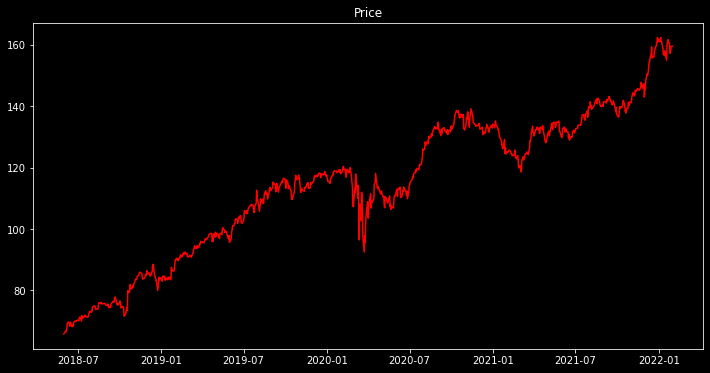

In [6]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
orig = plt.plot(df_copy.index[:925], train['Close'], color='red')
plt.title('Price')
plt.grid(False)

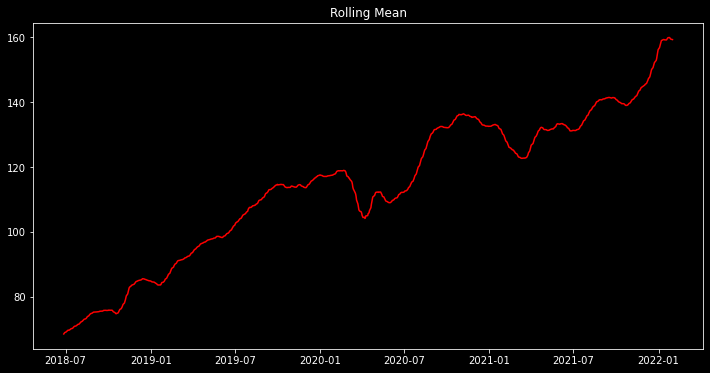

In [7]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
mean = plt.plot(df_copy.index[:925],train['rolmean'], color='red')
plt.title('Rolling Mean')
plt.grid(False)

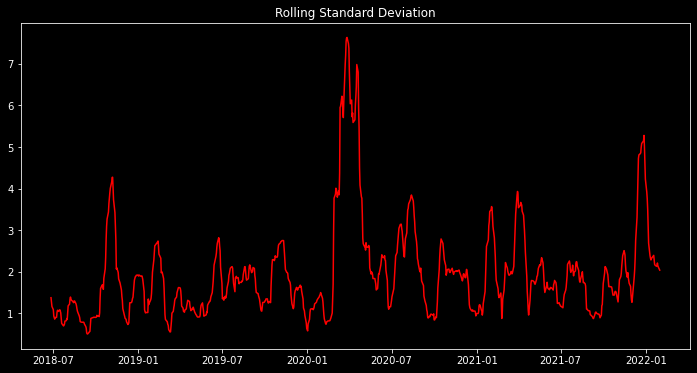

In [8]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
std = plt.plot(df_copy.index[:925],train['rolstd'], color='red')
plt.title('Rolling Standard Deviation')
plt.grid(False)

Visually we can see clearly that PG has been trending higher for the past 5 years, it’s been making higher highs and higher lows, and on a monthly bases,  the mean is also trending higher and the standard deviation is also not constant and fluctuates over time

#### Statistical test:
To check for stationary statistically we use the Augmented Dickey-Fuller(ADF) which is more accurate than making a visual observation.

In statistics and econometrics, an augmented Dickey–Fuller test is used to test whether a given time series is stationary or not. 

The p-value resulting from the ADF test has to be less than 0.05 or 5% for a time series to be stationary. If the p-value is greater than 0.05 or 5%, you conclude that the time series has a unit root which means that it is a non-stationary process.

In [9]:
result = adfuller(df['Close'])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.7582424618957933
p-value : 0.4013812122884916
#Lags Used : 9
Number of Observations Used : 1018
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


We have made a mathematical and empirical observation that our time series is not stationary hence we rule out the idea of using an ARMA model because we in fact do need to difference our time series inorder  to achieve (weak) stationarity

#### Differencing:

Differencing is a method of making a times series dataset stationary, by subtracting the observation in the previous time step from the current observation. This process can be repeated more than once, and the number of times differencing is performed is called the difference order.

Let’s look at the equation again:

#### *$Y_{t}^′ = Y_{t} − Y_{t−1}$*

So now the question is at what difference order? Once, twice?. The aim is to avoid over-differencing because it can lead to loss of valuable information about the time series and this often affects the construction of the model

We could repeat the visual and statistical test every time we difference our time series but fortunately, there is a helpful package we can use called pmdarima and it will tell us at what order should we difference our time series
(under the hood it repeats our statistical test and constantly checks at what order will the null hypothesis be rejected)



In [10]:
# from pmdarima.arima.utils import ndiffs
ndiffs(train['Close'], test="adf")

1

So in order to make the series stationary we only need to difference it once!

Augmented Dickey-Fuller Test:
ADF Test Statistic : -10.202850337835578
p-value : 5.90798356244438e-18
#Lags Used : 8
Number of Observations Used : 915
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


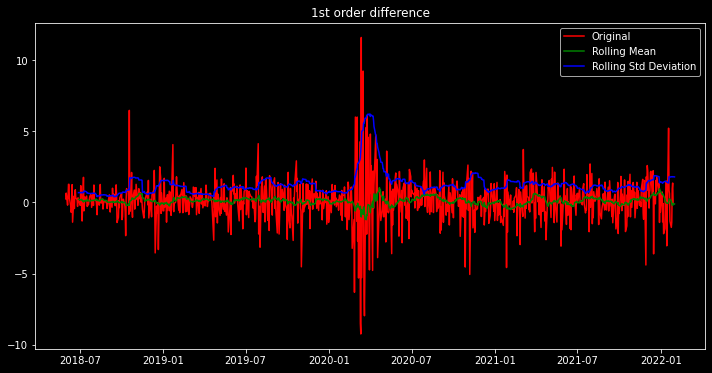

In [11]:
diff = train['Close'].diff().dropna()
diff_rolmean = diff.rolling(20).mean()
diff_rolstd = diff.rolling(20).std()

plt.figure(figsize=(12, 6))
plt.plot(df_copy.index[:924],diff, color='red', label='Original')
plt.plot(diff_rolmean, color='green', label='Rolling Mean')
plt.plot(diff_rolstd, color='blue', label = 'Rolling Std Deviation')
plt.title('1st order difference')
plt.legend(loc='best')
plt.grid(False)

result2 = adfuller(diff)
print('Augmented Dickey-Fuller Test:')

for value,label in zip(result2,labels):
    print(label+' : '+str(value) )
    
if result2[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Note: after differencing we can see it does look stationary but it is obvious that there are huge fluctuations in mid-2020 this was due to volatility being extremely high, in fact, On March 16, 2020, the VIX closed at a record high of 82.69 as investors and traders reacted to the pandemic.

So now we have the “d” value in the ARIMA which is 1

ARIMA(p,1,q)


### Finding the "p" and "q" value using PACF and ACF:

The next step is to determine the appropriate order of AR (p) and MA(q) processes by using the Partial Autocorrelation function (PACF)and Autocorrelation function (ACF)

#### PACF for AR(p):
The order, p, of the autoregressive model can be determined by looking at the partial autocorrelation function (PACF) plot. Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. In other words, partial autocorrelation is the relation between observed at two-time spots given that we consider both observations are correlated to the observations at other time spots. For example, today’s stock price can be correlated to the day before yesterday, and yesterday can also be correlated to the day before yesterday… day 1 with day 3, day 2 with day 3

#### ACF for MA(q):
The order q can be determined by the Autocorrelation Function plot (ACF) which checks for correlation between two different data points of a Time Series separated by a lag “h”. For example, for lag 1, today’s stock price can be correlated with yesterday’s and yesterday's stock price and can be correlated with the day before yesterday… day 1 with day 2, day 2 with day 3, etc, etc


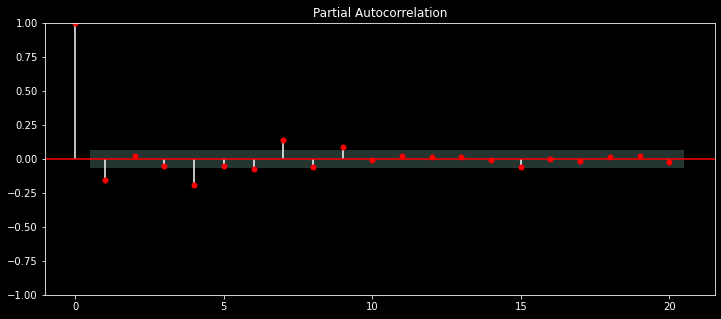

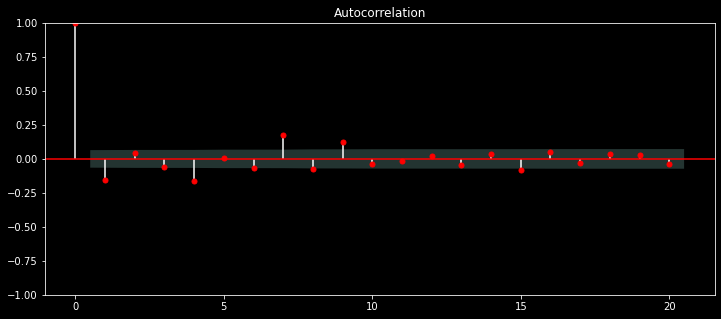

In [12]:
plt.style.use('dark_background')

#PACF to find p
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(diff, lags=20, ax=ax,color='red')
plt.grid(False)

#ACF to find q
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(diff, lags=20, ax=ax, color='red') 
plt.grid(False)


#### PACF and ACF Plot: 
The light/shaded area shows the significant threshold value, and every vertical line indicates the PACF and ACF values at each time spot. So in the plot, only the vertical lines that exceed the light/shaded red area are considered significant. 

For PACF we can see that the PACF lag 1,4,7,9 and 15 are significant, but I will pick lag 7 since it is well above the significance line compared to the rest. So, we will set the AR(p) value equal to 7.

While for the ACF, the lags 1,4,7 and 9 are significant, but lag 4 seems to be well above the significance line compared to the other lags. So, we will set the MA(q) value equal to 4.


NOTE: Before we continue something useful to remember is that the ACF can also be used to check for stationarity, for a stationary series, the autocorrelation in the ACF plot should decay quickly; with a non-stationary series, the ACF will decay slowly as we’ve already seen

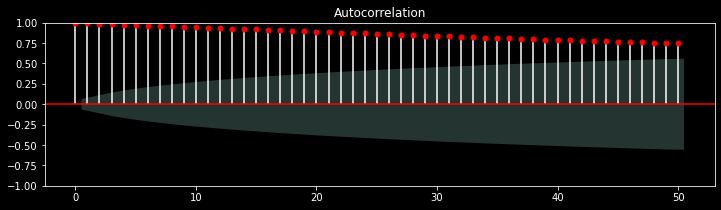

In [13]:
#ACF example for checking stationarity
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,3))
plot_acf(train['Close'], lags=50, ax=ax,color='red')
plt.grid(False)

So we have our “p” and “q” values, which are 7 and 4.

ARIMA(7,1,4)


### **Model development & Evaluation**:

Now that we have determined the parameters (p,d,q), we will estimate the accuracy of the ARIMA model on a training data set and then use the fitted model to forecast the values of the test data set using a forecasting function. In the end, we cross-check whether our forecasted values are in line with the actual values.

In [14]:
# ARIMA Model
model = ARIMA(train['Close'], order=(7,1,4))
result = model.fit()

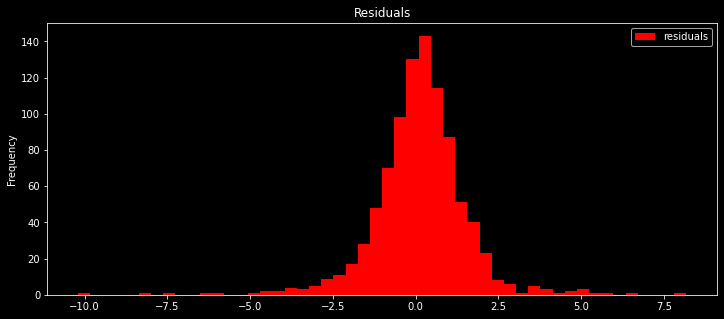

In [15]:
#Histogram to plot residuals
residuals = pd.DataFrame({'residuals':result.resid})
plt.style.use('dark_background')
residuals[1:].plot(kind='hist',bins=50,figsize=(12,5),color='red')
plt.title('Residuals')
plt.grid(False)

The residuals are the error based of what it would predict for the train data, the closer the residuals are to zero the better

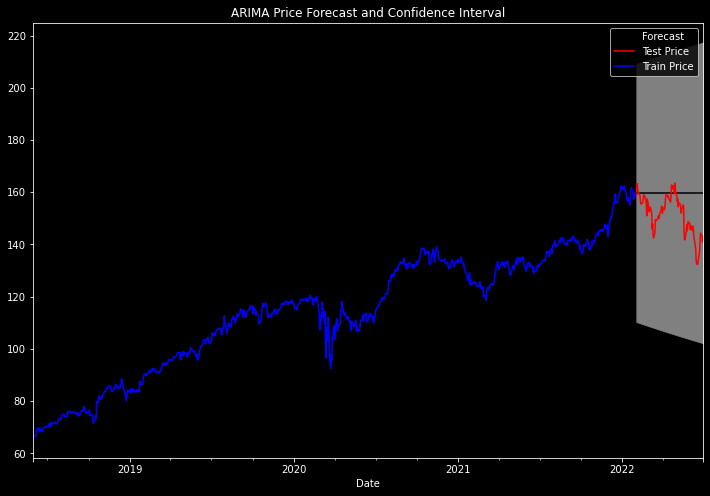

In [16]:
pred = result.get_forecast('2022-06-29').summary_frame()
pred = pred['2022-02-01':]

plt.style.use('dark_background')
pred['mean']['2022-02-01':].plot(figsize=(12,8),color='black',label='Forecast')
test['Close'].plot(figsize=(12,8),color='red',label='Test Price')
train['Close'].plot(figsize=(12,8),color='blue',label='Train Price')

#plt.fill_between(pred.index, pred['mean_ci_lower'], pred['mean_ci_upper'], color='k', alpha=0.1);
plt.fill_between(pred.index, pred['mean_ci_lower'], pred['mean_ci_upper'], 
                 color='gray')
plt.title('ARIMA Price Forecast and Confidence Interval')
plt.legend(loc='best')
plt.grid(False)

In [17]:
pred['mean']['2022-02-01':]

2022-02-01    159.739671
2022-02-02    159.739671
2022-02-03    159.739671
2022-02-04    159.739671
2022-02-05    159.739671
                 ...    
2022-06-25    159.739671
2022-06-26    159.739671
2022-06-27    159.739671
2022-06-28    159.739671
2022-06-29    159.739671
Freq: D, Name: mean, Length: 149, dtype: float64

The values seem to be flat, hence the prediction is far from accurate at the very least I was expecting the model to predict a trend in either direction

A possible solution to get a more accurate result using the ARIMA would be to test with different lags, remember we got several lags that we could’ve used, we can test a combination of all of them to find the one which can offer better result

But obviously, this will take time, a solution to that is to use the same package that we used to get the number of differencing needed to make our time series stationary. 


### AUTO ARIMA:
We can implement the Auto ARIMA model using the pmdarima time-series library which provides the auto_arima() function that automatically generates the optimal parameter values for all 3 p,d,q values 

The `auto_arima()` function can take a number of paramters but to keep it simple i'll just run the function and get the default best model, all we need to do is  just pass in our time series data.

In [18]:
from pmdarima.arima import auto_arima
auto_arima = auto_arima(train["Close"])
auto_arima

ARIMA(order=(4, 1, 5), scoring_args={}, suppress_warnings=True)

In [19]:
print(f'The default best value is {auto_arima.fit(train["Close"])}')

The default best value is  ARIMA(4,1,5)(0,0,0)[0] intercept


In [20]:
# ARIMA Model
model2 = ARIMA(train['Close'], order=(4,1,5))
result2 = model2.fit()

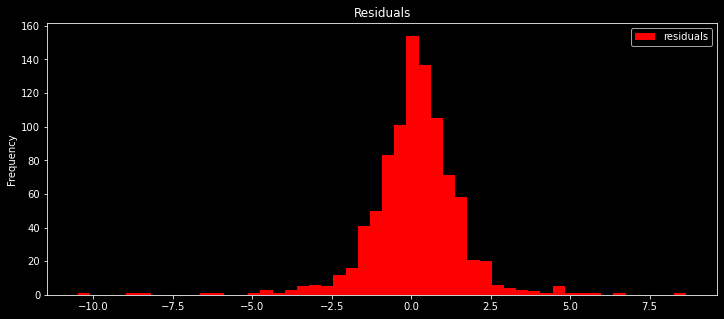

In [21]:
#Histogram
residuals2 = pd.DataFrame({'residuals':result2.resid})
plt.style.use('dark_background')
residuals2[1:].plot(kind='hist',bins=50,figsize=(12,5),color='red')
plt.title('Residuals')
plt.grid(False)

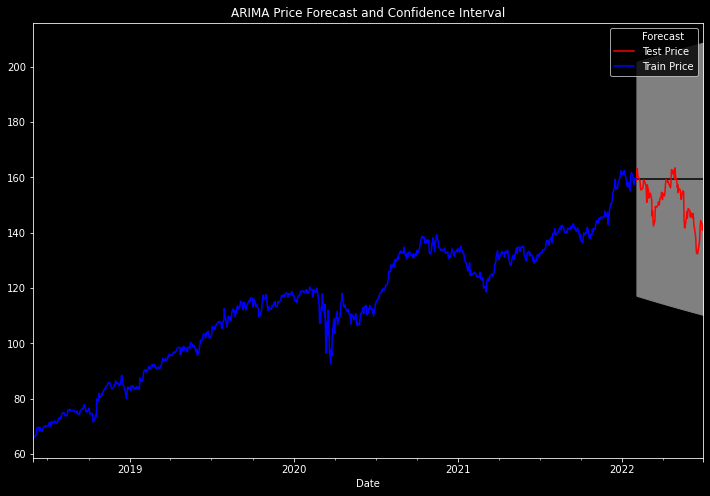

In [22]:
pred2 = result2.get_forecast('2022-06-29').summary_frame()
pred2 = pred2['2022-02-01':] 

plt.style.use('dark_background')
pred2['mean']['2022-02-01':].plot(figsize=(12,8),color='black',label='Forecast')
test['Close'].plot(figsize=(12,8),color='red',label='Test Price')
train['Close'].plot(figsize=(12,8),color='blue',label='Train Price')

plt.fill_between(pred2.index, pred2['mean_ci_lower'], pred2['mean_ci_upper'], 
                 color='gray')
plt.title('ARIMA Price Forecast and Confidence Interval')
plt.legend(loc='best')
plt.grid(False)

In [23]:
pred2['mean']['2022-02-01':]

2022-02-01    159.472243
2022-02-02    159.472243
2022-02-03    159.472243
2022-02-04    159.472243
2022-02-05    159.472243
                 ...    
2022-06-25    159.472243
2022-06-26    159.472243
2022-06-27    159.472243
2022-06-28    159.472243
2022-06-29    159.472243
Freq: D, Name: mean, Length: 149, dtype: float64

### **Conclusion**:
Even after the default best model, the values haven't changed much as they look constant from afar.

Stock data is complex and are usually composed of linear and non-linear components. So just using a linear model to make predictions will not be efficient, especially using ARIMA to predict prices as we saw didn’t provide a realistic prediction, they may however be useful to predict the overall trend of a time series.

Alternatively, we could try and predict stock returns instead because returns are considered stationary(at least visually) or we could use the SARIMA (Seasonal Auto-Regressive Integrated Moving Average) model which is an extension of the ARIMA, it adds seasonal components of the time series that can help improve prediction.

But again something to remember is that even if we continue to fine-tune the ARIMA and SARIMA models, the prediction could still be inaccurate because we will still be using univariate data, in order to get the best predictions it’s better to use multivariate data like using the closing prices or stock return of other correlated consumer staple stocks like Colgate-Palmolive Company (TICKER: CL) or The Clorox Company (TICKER: CLX) using models like the ARIMAX or SARIMAX which are just an extension of the ARIMA and SARIMA models, The ‘X’ stands for an exogenous variable(or variables) and in this example, CL and CLX could be those exogenous variables.

For now, my knowledge is still limited, more time is needed to research and learn about other models as well learning in-depth analysis and forecasting techniques, hence, In future blogs, I will try and incorporate all relevant models and leverage the pmdarima package even further by adding extra parameters to try to find the most accurate model 
